<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/cursivetransformer_mech_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Induction Circuit Investigation and Analysis

# Setup

In [1]:
!pip install transformer_lens
!pip install gradio
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install datasets

# Clone the cursivetransformer repository and install its requirements
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git
!pip install -r cursivetransformer/requirements.txt

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.

In [2]:
import sys
sys.path.append('/content/cursivetransformer')
from cursivetransformer.model import get_all_args, get_checkpoint, get_latest_checkpoint_artifact
from cursivetransformer.data import create_datasets, offsets_to_strokes, strokes_to_offsets
from cursivetransformer.sample import generate, generate_n_words, plot_strokes
from cursivetransformer.mech_interp import (
    HookedCursiveTransformer,
    HookedCursiveTransformerConfig,
    convert_cursivetransformer_model_config,
    visualize_attention,
    generate_repeated_stroke_tokens,
    generate_random_ascii_context,
    run_and_cache_model_repeated_tokens,
    compute_induction_scores,
    plot_induction_scores,
    plot_head_attention_pattern,
    create_induction_summary,
    ablate_heads,
    get_induction_positions,
    compute_loss_on_induction_positions
)

import pandas as pd
import os

import copy
import types
from typing import List, Callable, Dict, Optional, Union, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import circuitsvis as cv
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from jaxtyping import Float, Int


import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from transformer_lens import ActivationCache

torch.set_grad_enabled(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'
args.wandb_entity = 'sam-greydanus'
args.dataset_name = 'bigbank'
args.wandb_run_name = 'cursivetransformer_dictionary_learning'

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)

args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()

Trying to load dataset file from /content/cursivetransformer/data/bigbank.json.zip
Succeeded in loading the bigbank dataset; contains 1900 items.
For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples


## Load model into HookedCursiveTransformer

In [4]:
cfg = convert_cursivetransformer_model_config(args)
model = HookedCursiveTransformer.from_pretrained("cursivetransformer", cfg)

Loading pretrained model cursivetransformer
Finding latest checkpoint for W&B run id 6le6tujz
  model:best_checkpoint:v70
  model:best_checkpoint:v71
  model:best_checkpoint:v72
  model:best_checkpoint:v73
  model:best_checkpoint:v74
  model:best_checkpoint:v75
  model:best_checkpoint:v76
  model:best_checkpoint:v77
  model:best_checkpoint:v78
  model:best_checkpoint:v79
  model:best_checkpoint:v80
  model:best_checkpoint:v81
  model:best_checkpoint:v82
  model:best_checkpoint:v83
  model:best_checkpoint:v84
  model:best_checkpoint:v85
  model:best_checkpoint:v86
  model:best_checkpoint:v87
  model:best_checkpoint:v88
  model:best_checkpoint:v89
  wandb-history:run-6le6tujz-history:v4
Selected:  model:best_checkpoint:v89


wandb:   1 of 1 files downloaded.  


Successfully loaded pretrained model cursivetransformer


# Experiment

Moving model to device:  cuda


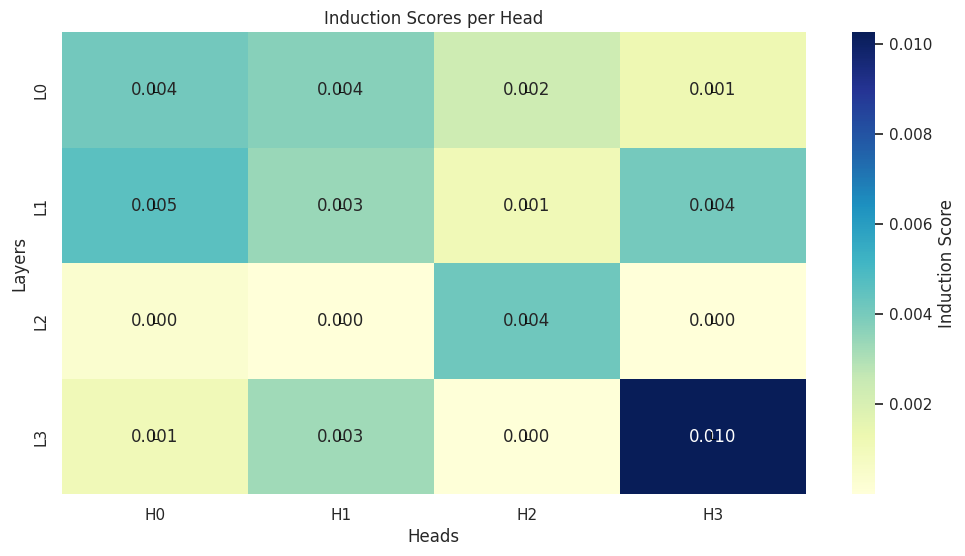

In [5]:
seq_len = 50  # Number of (θ, r) pairs in the initial sequence <- [ ] TODO: DEBUG THIS!
n_repeats = 2  # Number of repetitions
batch_size = 1

# Generate repeated stroke tokens and random ASCII context
rep_tokens = generate_repeated_stroke_tokens(model, test_dataset, seq_len, n_repeats, batch_size)
context_tokens = generate_random_ascii_context(model, batch_size)

# Run the model and cache activations
model = model.to(device)
logits, targets, cache = run_and_cache_model_repeated_tokens(model, rep_tokens.to(device), context_tokens.to(device))

# sanity_check_token_pairs(rep_tokens)
# verify_attention_summation(cache, layer=2, head=3, attn_type='self')

induction_scores = compute_induction_scores(rep_tokens, cache, model)
plot_induction_scores(induction_scores)

Top 5 Induction Heads:
1. Layer 3, Head 3, Induction Score: 0.0103


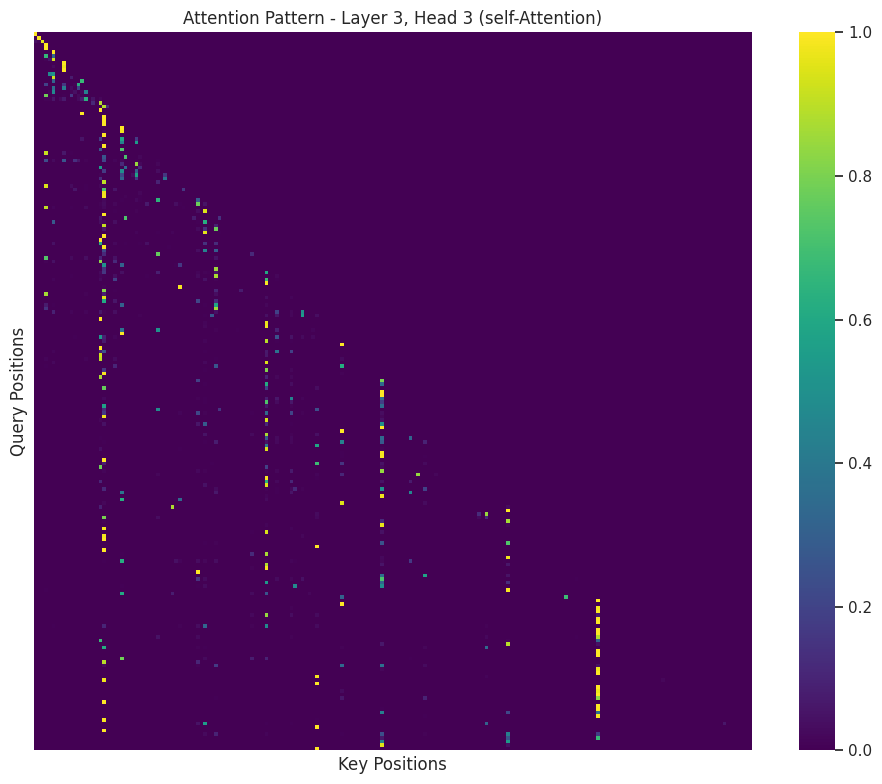

2. Layer 1, Head 0, Induction Score: 0.0046


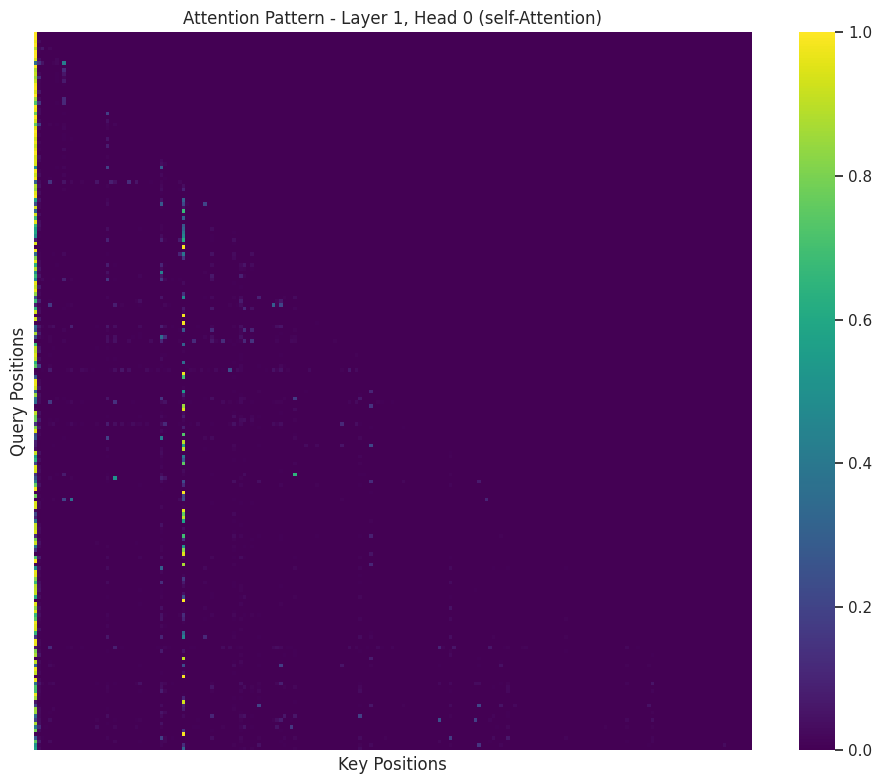

3. Layer 2, Head 2, Induction Score: 0.0042


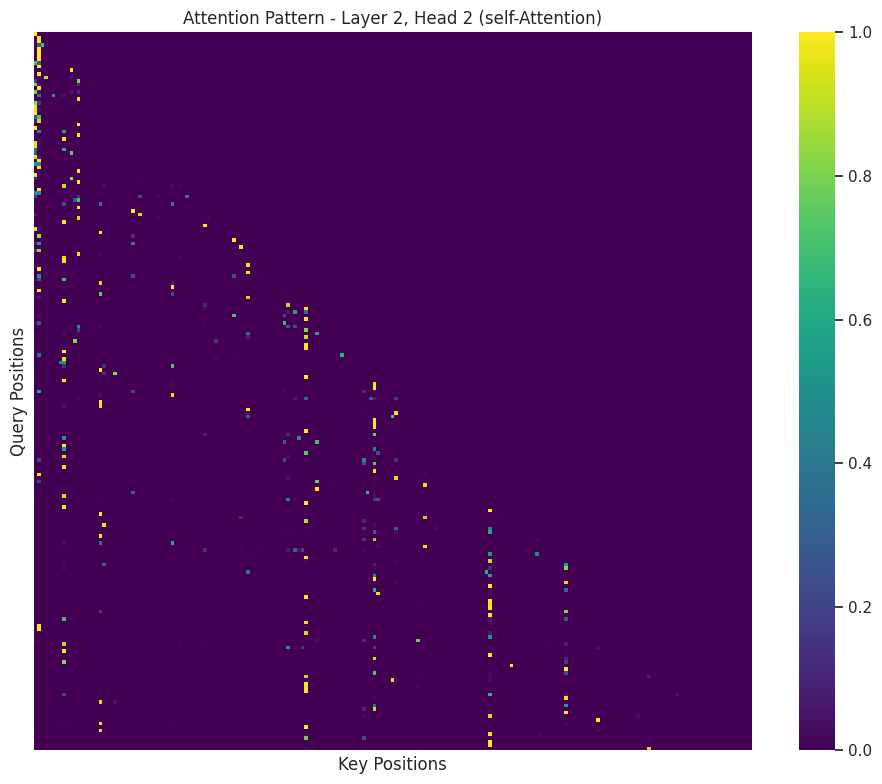

4. Layer 0, Head 0, Induction Score: 0.0041


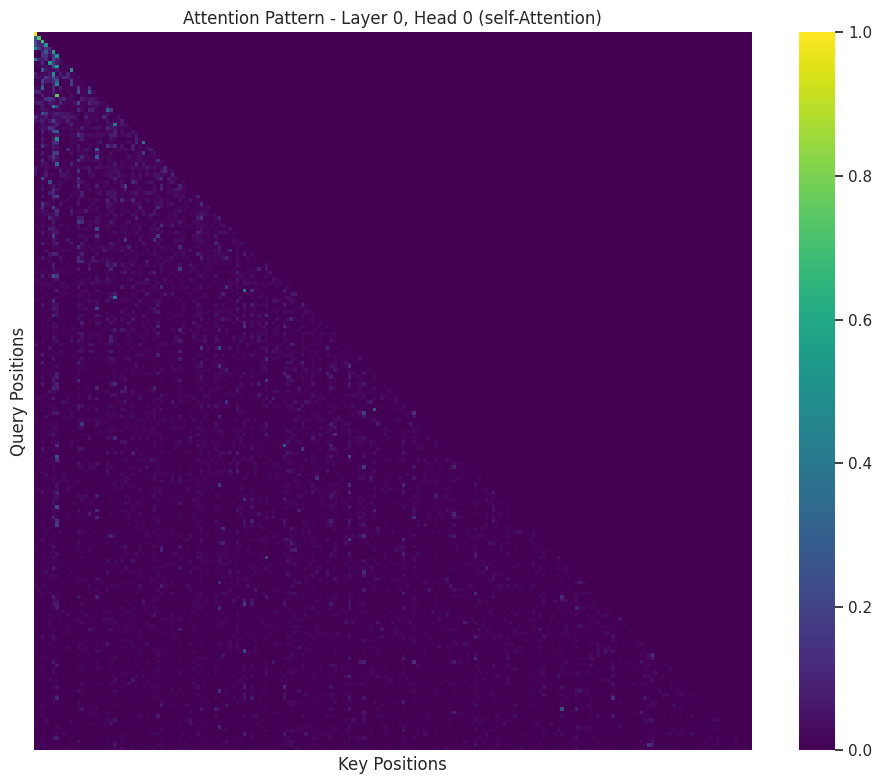

5. Layer 1, Head 3, Induction Score: 0.0041


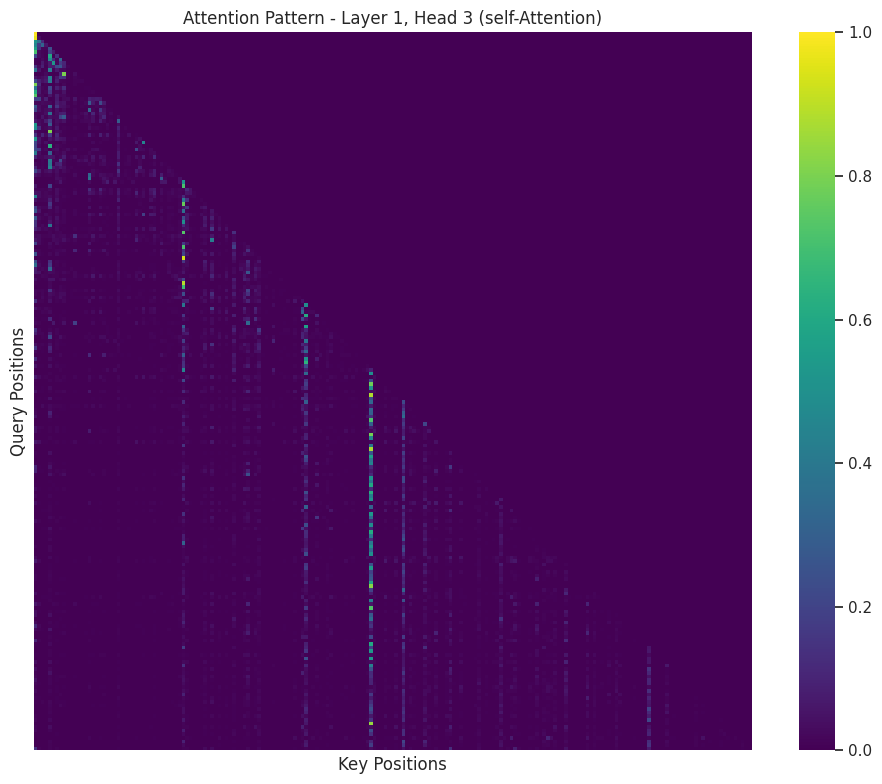

In [6]:
# Identify top N heads with highest induction scores
N = 5
induction_scores_flat = induction_scores.view(-1)
top_scores, top_indices = torch.topk(induction_scores_flat, N)
num_heads = model.cfg.n_heads

print(f"Top {N} Induction Heads:")
for rank, (score, idx) in enumerate(zip(top_scores, top_indices), start=1):
    layer = idx // num_heads
    head = idx % num_heads
    print(f"{rank}. Layer {layer}, Head {head}, Induction Score: {score:.4f}")
    # Plot attention pattern
    plot_head_attention_pattern(cache, layer, head, seq_len * n_repeats * 2, attn_type='self')

In [7]:
# Create and display summary table
df_induction = create_induction_summary(induction_scores)
display(df_induction.sort_values(by='Score', ascending=False))

,Layer,Head,Score,Category
15,3,3,1.026279e-02,Low
4,1,0,4.582501e-03,Low
10,2,2,4.197625e-03,Low
0,0,0,4.129122e-03,Low
7,1,3,4.070452e-03,Low
1,0,1,3.712228e-03,Low
5,1,1,3.391204e-03,Low
13,3,1,3.252505e-03,Low
2,0,2,2.363611e-03,Low
3,0,3,1.204299e-03,Low


In [13]:
threshold = 0.0001
# Example head_list with attention types
heads_to_ablate = [
    (layer_idx, head_idx, 'self')  # or 'cross'
    for layer_idx in range(model.cfg.n_layers)
    for head_idx in range(model.cfg.n_heads)
    if induction_scores[layer_idx, head_idx] > threshold
]

# Run ablation with corrected hook names
ablated_logits = ablate_heads(model, heads_to_ablate, rep_tokens, context_tokens)

# Print shapes for debugging
print(f"rep_tokens shape: {rep_tokens.shape}")
print(f"logits shape: {logits[0].shape}")
print(f"targets shape: {targets.shape}")

# Get induction positions
induction_positions = get_induction_positions(rep_tokens, seq_len, n_repeats)
print(f"Induction positions: {induction_positions}")

# Ensure induction_positions are within bounds
max_position = logits[0].shape[1] - 1  # Assuming logits shape is (batch_size, seq_len, vocab_size)
induction_positions = induction_positions[0]  # Unpack the tensor from the list
induction_positions = [pos for pos in induction_positions if pos <= max_position]
print(f"Filtered induction positions: {induction_positions}")

# Compute loss on induction positions
if len(induction_positions) > 0:
    original_loss = compute_loss_on_induction_positions(logits, targets, induction_positions)
    ablated_loss = compute_loss_on_induction_positions(ablated_logits, targets, induction_positions)

    print(f"Original Loss on Induction Positions: {original_loss.item():.4f}")
    print(f"Ablated Loss on Induction Positions: {ablated_loss.item():.4f}")
else:
    print("No valid induction positions found within the sequence length.")

rep_tokens shape: torch.Size([1, 200])
logits shape: torch.Size([1, 199, 455])
targets shape: torch.Size([1, 199])
Induction positions: [tensor([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
        198, 199], device='cuda:0')]
Filtered induction positions: [tensor(100, device='cuda:0'), tensor(101, device='cuda:0'), tensor(102, device='cuda:0'), tensor(103, device='cuda:0'), tensor(104, device='cuda:0'), tensor(105, device='cuda:0'), tensor(106, device='cuda:0'), tensor(107, device='cuda:0'), tensor(10